# Определение возраста покупателей

Описание проекта:
<br>Сетевой супермаркет внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:

* Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
* Контролировать добросовестность кассиров при продаже алкоголя.

<br>***Постройте модель, которая по фотографии определит приблизительный возраст человека***. 
<br>В вашем распоряжении набор фотографий людей с указанием возраста.

Инструкция по выполнению проекта:
* Проведите исследовательский анализ набора фотографий;
* Подготовьте данные к обучению;
* Обучите нейронную сеть и рассчитайте её качество.


## Исследовательский анализ данных

In [1]:
# Загрузка библиотек
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
# Путь к файлам
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


In [3]:
# Перечень столбцов
labels.head(7)

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17
5,000005.jpg,27
6,000006.jpg,24


In [4]:
# Проверка типов данных
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
file_name    7591 non-null object
real_age     7591 non-null int64
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [5]:
# Статистические величины по 'real_age'
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


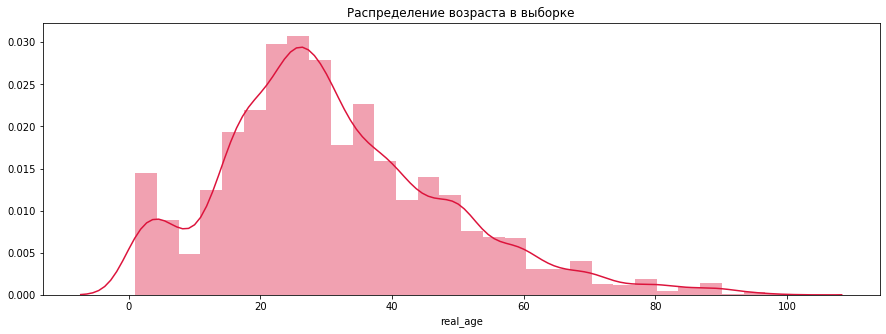

In [6]:
# Гистограмма распределения возраста в выборке
plt.figure(figsize=(15,5))
sns.distplot(labels['real_age'], color='crimson', bins=30)
plt.title("Распределение возраста в выборке")
plt.show()


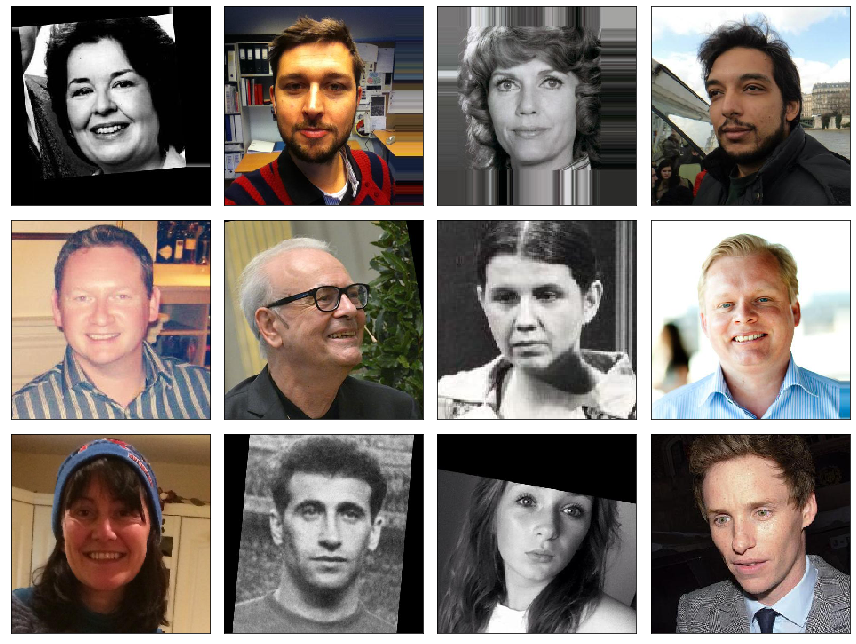

In [10]:
# Случайная выборка фотографий для обучения модели
features, target = next(train_gen_flow)

fig = plt.figure(figsize=(12,12))
for i in range(12):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

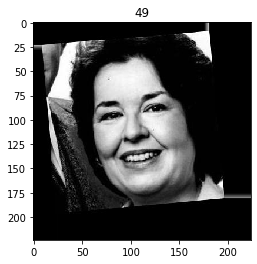

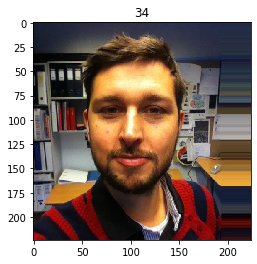

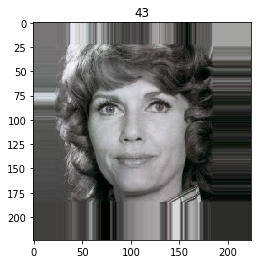

In [15]:
# Выборка фотографий с указанием реального возраста людей
for age, photo in zip(target[:3], features[:3]):
    plt.figure()
    plt.title(age)
    plt.imshow(photo)

### Вывод:
Для задания представлена небольшая выборка с 7591 фотографиями, из них рандомно выбрано 12 шт.
<br>Возрастной диапазон выборки 1-100 лет, основной массив фото с возрастом людей 20-41, в среднем около 30 лет, наблюдается пик на милых детских фото до 5 лет. Случайным образом соотношение в выборке мужчины/женщины: 7/5.
<br>В предложенной выборке малое количество фотографий людей после 60 лет, есть вероятность, что модель будет недостаточно хорошо их определять, возможно стоит подумать о пополнении фото по этой возрастной категории или синтезировать их, применить аугментацию.
<br>Фотографии разного качества, в том числе черно-белые, с поворотом головы, сверхяркие, есть дополнительные спецэффекты обработки, присутствуют дополнительные предметы- очки, головной убор, что будет представлять ряд сложностей для обучения модели.


## Обучение модели

Код раздела запускается в отдельном GPU-тренажёре.
<br> Код и вывод представлен ниже.

##### Код:

```python
import numpy as np
from tensorflow.keras.layers import Conv2D, Flatten, AvgPool2D, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50 
 
 
def load_train(path):
    labels = pd.read_csv(path+'labels.csv')                                                     
    train_datagen = ImageDataGenerator(rescale= 1./255, validation_split=0.25)  
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe = labels,
        directory = path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        horizontal_flip=True,
        seed=12345)
    return train_datagen_flow
 
def load_test(path):
    labels = pd.read_csv(path+'labels.csv')  
    test_datagen = ImageDataGenerator(rescale= 1./255, validation_split=0.25)  
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe = labels,
        directory = path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation', 
        seed=12345)
 
    return test_datagen_flow
 
def create_model(input_shape):
 
    backbone = ResNet50(input_shape= input_shape,
                    weights='imagenet', 
                    include_top= False)
 
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae']) 
    return model
 
 
def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):
 
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
    model.fit(train_data, 
              validation_data= test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
    return model

```

##### Вывод:

```
Epoch 1/10
178/178 - 99s - loss: 205.0102 - mae: 10.5819 - val_loss: 317.3405 - val_mae: 13.2126
Epoch 2/10
178/178 - 41s - loss: 96.4598 - mae: 7.4412 - val_loss: 443.4091 - val_mae: 15.8325
Epoch 3/10
178/178 - 41s - loss: 64.0527 - mae: 6.1343 - val_loss: 301.9018 - val_mae: 12.8919
Epoch 4/10
178/178 - 41s - loss: 43.2806 - mae: 5.0341 - val_loss: 149.8389 - val_mae: 9.1190
Epoch 5/10
178/178 - 41s - loss: 29.6981 - mae: 4.2136 - val_loss: 104.9151 - val_mae: 7.5741
Epoch 6/10
178/178 - 41s - loss: 20.6762 - mae: 3.5109 - val_loss: 81.3642 - val_mae: 6.6892
Epoch 7/10
178/178 - 40s - loss: 17.3920 - mae: 3.2108 - val_loss: 87.1265 - val_mae: 6.9833
Epoch 8/10
178/178 - 41s - loss: 13.5037 - mae: 2.8095 - val_loss: 73.9750 - val_mae: 6.4053
Epoch 9/10
178/178 - 41s - loss: 10.7918 - mae: 2.5193 - val_loss: 80.2930 - val_mae: 6.7702
Epoch 10/10
178/178 - 40s - loss: 8.8153 - mae: 2.2726 - val_loss: 69.1264 - val_mae: 6.3527
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 10s - loss: 69.1264 - mae: 6.3527
Test MAE: 6.3527

```

### Вывод:
Для обучения модели использована сверточная нейронная сеть ResNet50. MAE- 6.3 достигнуто на 10 эпохах.

## Анализ обученной модели

Несмотря на ряд недостатков исследуемых фотографий и небольшой объем выборки модель ResNet50 достигла качества MAE- 6.3. 
<br>При определении возраста модель ошибается на 6 лет. На практике при определении сколько лет взрослому человеку подобное отклонение допустимо считать незначительным.
<br>ResNet показывает такие потрясающие результаты за счет нескольких ансамблей параллельных или последовательных модулей, а благодаря возвращению выходного сигнала назад и подаче как входного (подаём выходные данные двух успешных свёрточных слоёв и обходим входные данные для следующего слоя) она приближена к модели коры головного мозга человека.
<br>Применительно к решению задач обозначенных бизнесом данная модель может  эффективно стимулировать рост продаж с помощью аналитики покупок/ возраста покупателей и помогать в соблюдении правил продажи алкогольной продукции кассирами супермаркета.
